In [1]:
import sys
from pathlib import Path
PROJECT_ROOT = Path().resolve().parents[0]
print(PROJECT_ROOT)
sys.path.insert(0, str(PROJECT_ROOT))
from utils import show_clustering_report
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyclustering.cluster.clarans import clarans

C:\Users\anfel\OneDrive\Desktop\M2\prjt


# Loading the Dataset

In [2]:
dataset = pd.read_parquet(r'../local_dataset/dataset/merged_full2.parquet')

# Keep lon/lat for visualization only
lon_lat = dataset[['lon', 'lat']].copy()

# Remove lon/lat and fire from clustering
dataset.drop(columns=['lon', 'lat', 'fire'], inplace=True, errors='ignore')
print("=== Dataset Types :\n", dataset.dtypes)

dataset_numeric_columns = dataset.select_dtypes(include=['number']).columns
dataset_string_columns = dataset.select_dtypes(include=['object']).columns
dataset[dataset_numeric_columns] = dataset[dataset_numeric_columns].fillna(dataset[dataset_numeric_columns].mean())
dataset[dataset_string_columns] = dataset[dataset_string_columns].fillna(dataset[dataset_string_columns].mode().iloc[0])

print("=== Null Values :\n", dataset.isnull().sum())

X = dataset.copy()
X_string_columns = X.select_dtypes(include=['object']).columns
X[X_string_columns] = OrdinalEncoder().fit_transform(X[X_string_columns])
X_numeric_columns = X.select_dtypes(include=['number']).columns
X[X_numeric_columns] = StandardScaler().fit_transform(X[X_numeric_columns])

print("=== X shape:", X.shape)
print("=== X columns:", X.columns)

X_array = X.to_numpy()

=== Dataset Types :
 log_precip_s1             float64
log_precip_s2             float64
log_precip_s3             float64
log_precip_s4             float64
tmax_s1                   float64
tmax_s2                   float64
tmax_s3                   float64
tmax_s4                   float64
amplitude_thermique_s1    float64
amplitude_thermique_s2    float64
amplitude_thermique_s3    float64
amplitude_thermique_s4    float64
GRIDCODE                  float64
log_area_sqm              float64
lcc_code_encoded          float64
elevation                 float32
COARSE                    float64
SAND                      float64
SILT                      float64
CLAY                      float64
TEXTURE_USDA              float64
TEXTURE_SOTER              object
BULK                      float64
REF_BULK                  float64
ORG_CARBON                float64
PH_WATER                  float64
TOTAL_N                   float64
CN_RATIO                  float64
CEC_SOIL                  f

# PCA

In [3]:
print(f"Nombre de features avant PCA : {X.shape[1]}")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(f"Nombre de features après PCA : {X_pca.shape[1]}")

Nombre de features avant PCA : 38
Nombre de features après PCA : 2


# Grid search

In [5]:
# --- Grid Search des hyperparamètres ---
param_grid = {
    "n_clusters": [3, 5, 7],
    "numlocal": [3, 5, 10],
    "maxneighbor": [10, 20, 30]
}

best_score = -np.inf
best_params = None

results = []

for n_clusters in param_grid["n_clusters"]:
    for numlocal in param_grid["numlocal"]:
        for maxneighbor in param_grid["maxneighbor"]:
            # --- Création du modèle Clarans ---
            model = clarans(X_pca, n_clusters, numlocal, maxneighbor)

            # --- Exécution du clustering ---
            model.process()
            clusters = model.get_clusters()

            # --- Calcul du score de silhouette ---
            labels = np.zeros(len(X_pca))
            for i, cluster in enumerate(clusters):
                for idx in cluster:
                    labels[idx] = i

            score = silhouette_score(X_pca, labels)

            # --- Stockage des résultats ---
            results.append({
                "n_clusters": n_clusters,
                "numlocal": numlocal,
                "maxneighbor": maxneighbor,
                "silhouette": score
            })

            # --- Mise à jour du meilleur score ---
            if score > best_score:
                best_score = score
                best_params = {
                    "n_clusters": n_clusters,
                    "numlocal": numlocal,
                    "maxneighbor": maxneighbor
                }

            print(f"n_clusters={n_clusters}, numlocal={numlocal}, maxneighbor={maxneighbor} -> silhouette: {score:.4f}")

print("======================================")
print("Meilleur score de silhouette :", best_score)
print("Meilleurs paramètres :", best_params)
print("======================================")

KeyboardInterrupt: 

# Scratch Model Implementation

In [6]:
import numpy as np

class CLARANS:
    
    def __init__(self, n_clusters=3, numlocal=2, maxneighbor=10, random_state=42):
        self.n_clusters = n_clusters
        self.numlocal = numlocal
        self.maxneighbor = maxneighbor
        self.random_state = random_state
        self.medoid_indices_ = None
        self.labels_ = None
        self.inertia_ = None
        
    def _compute_distance_matrix(self, X):
        """Compute pairwise Euclidean distances"""
        n = X.shape[0]
        dist_matrix = np.zeros((n, n))
        
        for i in range(n):
            dist_matrix[i] = np.linalg.norm(X - X[i], axis=1)
        
        return dist_matrix
    
    def _assign_clusters(self, dist_matrix, medoid_indices):
        """Assign each point to nearest medoid"""
        distances_to_medoids = dist_matrix[:, medoid_indices]
        labels = np.argmin(distances_to_medoids, axis=1)
        return labels
    
    def _compute_cost(self, dist_matrix, medoid_indices):
        """Compute total cost (sum of distances to nearest medoid)"""
        distances_to_medoids = dist_matrix[:, medoid_indices]
        min_distances = np.min(distances_to_medoids, axis=1)
        return np.sum(min_distances)
    
    def _get_random_neighbor(self, current_medoids, n_points):
        """Generate a random neighbor by swapping one medoid"""
        neighbor = current_medoids.copy()
        
        # Randomly select a medoid to replace
        medoid_to_replace = np.random.randint(0, self.n_clusters)
        
        # Randomly select a non-medoid point
        non_medoid_points = np.setdiff1d(np.arange(n_points), current_medoids)
        new_medoid = np.random.choice(non_medoid_points)
        
        neighbor[medoid_to_replace] = new_medoid
        return neighbor
    
    def fit(self, X):
        """Fit CLARANS clustering"""
        np.random.seed(self.random_state)
        n_points = X.shape[0]
        
        # Compute distance matrix once
        print("Computing distance matrix...")
        dist_matrix = self._compute_distance_matrix(X)
        
        best_medoids = None
        best_cost = np.inf
        
        print(f"Starting {self.numlocal} local searches...")
        
        for local_search in range(self.numlocal):
            # Initialize with random medoids
            current_medoids = np.random.choice(n_points, self.n_clusters, replace=False)
            current_cost = self._compute_cost(dist_matrix, current_medoids)
            
            neighbors_checked = 0
            
            while neighbors_checked < self.maxneighbor:
                # Get a random neighbor
                neighbor_medoids = self._get_random_neighbor(current_medoids, n_points)
                neighbor_cost = self._compute_cost(dist_matrix, neighbor_medoids)
                
                # If neighbor is better, move to it and reset counter
                if neighbor_cost < current_cost:
                    current_medoids = neighbor_medoids
                    current_cost = neighbor_cost
                    neighbors_checked = 0
                else:
                    neighbors_checked += 1
            
            # Update global best
            if current_cost < best_cost:
                best_cost = current_cost
                best_medoids = current_medoids
            
            print(f"Local search {local_search + 1}/{self.numlocal} completed. Cost: {current_cost:.2f}")
        
        # Store results
        self.medoid_indices_ = best_medoids
        self.labels_ = self._assign_clusters(dist_matrix, best_medoids)
        self.inertia_ = best_cost
        
        print(f"\nBest cost found: {best_cost:.2f}")
        print(f"Medoid indices: {best_medoids}")
        
        return self
    
    def predict(self, X_train, X_new):
        """Predict cluster labels for new data"""
        medoid_points = X_train[self.medoid_indices_]
        labels = []
        
        for point in X_new:
            distances = np.linalg.norm(medoid_points - point, axis=1)
            labels.append(np.argmin(distances))
        
        return np.array(labels)

# Scratch Model Training

**Note**: En raison de la complexité computationnelle de CLARANS, nous utilisons un échantillon du dataset pour l'entraînement.

In [16]:
# Utiliser un échantillon pour l'entraînement (comme au début, 10000 points max)
sample_size = min(10000, len(X_pca))
np.random.seed(42)
sample_indices = np.random.choice(len(X_pca), sample_size, replace=False)
X_sample = X_pca[sample_indices]
lon_lat_sample = lon_lat.iloc[sample_indices].reset_index(drop=True)

print(f"Training CLARANS on sample of {sample_size} points...\n")

# Train CLARANS model
clarans = CLARANS(
    n_clusters=5,      # Number of clusters
    numlocal=2,        # Number of local searches
    maxneighbor=10,    # Max neighbors to check
    random_state=42
)

clarans.fit(X_sample)

labels_scratch = clarans.labels_

print(f"\nScratch CLARANS - Number of clusters: {clarans.n_clusters}")
print(f"Scratch CLARANS - Inertia: {clarans.inertia_:.2f}")

Training CLARANS on sample of 10000 points...

Computing distance matrix...
Starting 2 local searches...
Local search 1/2 completed. Cost: 12141.75
Local search 2/2 completed. Cost: 14577.37

Best cost found: 12141.75
Medoid indices: [3990 6892 9637 4742 7437]

Scratch CLARANS - Number of clusters: 5
Scratch CLARANS - Inertia: 12141.75


# Scratch Model Evaluation

Clustering Metrics
  WCSS (compactness)      : 22951.5235  (minimize)
  Silhouette Score        : 0.5243  (maximize)
  Davies-Bouldin Index    : 0.6360  (minimize)
  Calinski-Harabasz Index : 15958.8980  (maximize)
  Dunn Index              : 0.0011  (maximize)


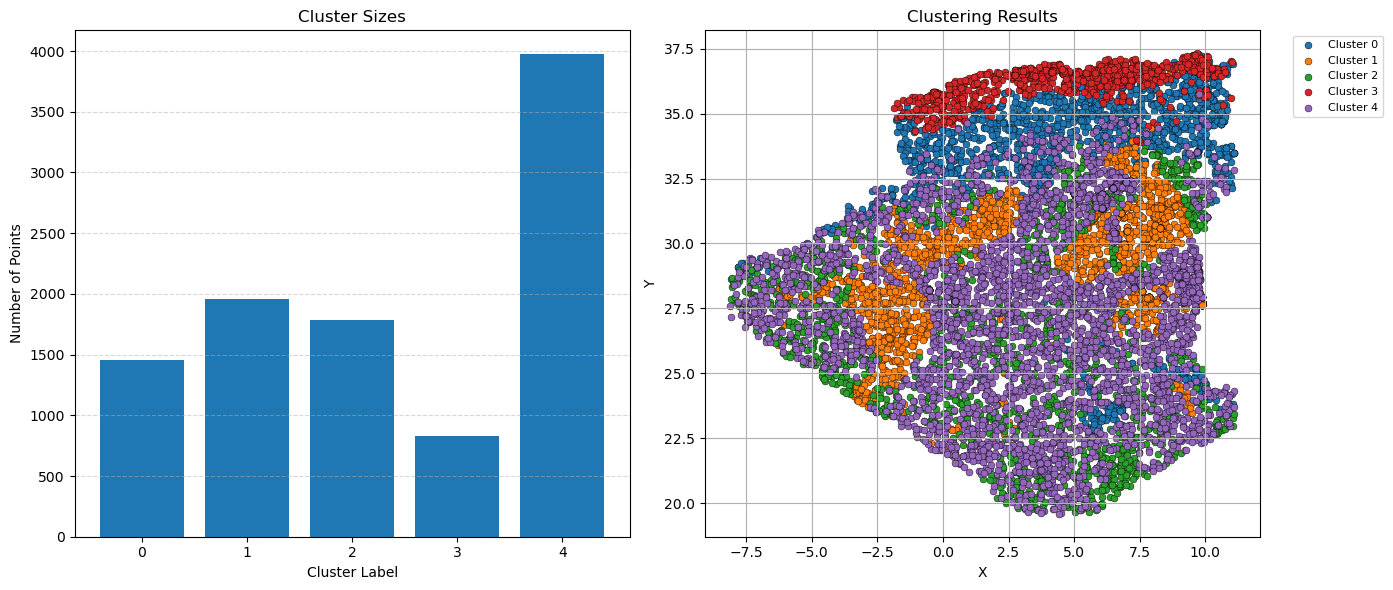

In [17]:
show_clustering_report(X_sample, lon_lat_sample.values, labels_scratch)

# SKlearn Model Training


In [18]:
from pyclustering.cluster.clarans import clarans

# Train CLARANS using pyclustering library
clarans_sklearn = clarans(X_sample.tolist(), 5, 2, 10)
clarans_sklearn.process()

# Get clusters and labels
clusters_sklearn = clarans_sklearn.get_clusters()
medoids_sklearn = clarans_sklearn.get_medoids()

# Convert clusters to labels
labels_sklearn = np.zeros(len(X_sample), dtype=int)
for cluster_id, cluster_points in enumerate(clusters_sklearn):
    for point_idx in cluster_points:
        labels_sklearn[point_idx] = cluster_id

print(f"Sklearn CLARANS - Number of clusters: {len(clusters_sklearn)}")
print(f"Sklearn CLARANS - Medoids: {medoids_sklearn}")


Sklearn CLARANS - Number of clusters: 5
Sklearn CLARANS - Medoids: [357, 185, 377, 3156, 3456]


# SKlearn Model Evaluation


Clustering Metrics
  WCSS (compactness)      : 98028.7889  (minimize)
  Silhouette Score        : 0.2403  (maximize)
  Davies-Bouldin Index    : 1.0135  (minimize)
  Calinski-Harabasz Index : 1822.7472  (maximize)
  Dunn Index              : 0.0002  (maximize)


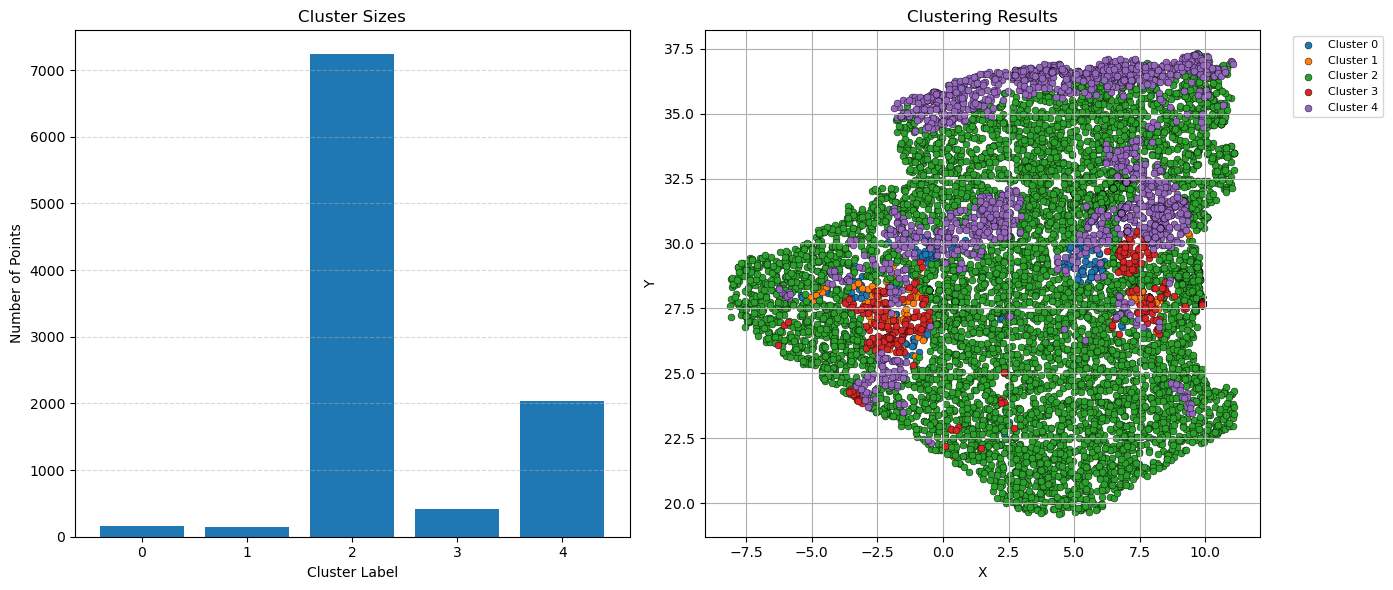

In [19]:
show_clustering_report(X_sample, lon_lat_sample.values, labels_sklearn)